In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
import random
import sys
import seaborn as sns
import pandas as pd

In [32]:
def get_data_in_dataframe(function_to_ages,ages_list):
    data = [] #function, ages_list, mean, std, len, rand_mean, rand_std
    for func in function_to_ages:
        curr = []
        ages = np.array(function_to_ages[func])
        
        #remove Nones
        ages = ages[ages != np.array(None)]
        if len(ages) == 0:
            continue
            
        #calculation of stats
        curr.append(func)
        curr.append(ages)
        curr.append(np.mean(ages))
        curr.append(len(ages))
            
            
        #random (based on num ages)
        ages_list = np.array(ages_list)
        ages_list = ages_list[ages_list != np.array(None)]
        rand_ages = np.array(random.sample(list(ages_list),len(ages)))
        curr.append(np.mean(rand_ages))
        data.append(curr)
        
        
    df = pd.DataFrame(data)
    df.columns = ['function_name','ages_list',
                  'age_mean','num_els',
                  'rand_age_mean']
    return df

In [19]:
dataset_to_gene_to_age_dict = pickle.load(open("data/dataset_to_gene_to_age_dict.p","rb"))  
dataset_list = dataset_to_gene_to_age_dict.keys()
dataset_list = list(dataset_list)
print (dataset_list)

dataset_to_function_to_age_dict = {}
dataset_to_ages_list = {}
for dataset in dataset_list:
    function_to_age_dict = pickle.load(open("data/function_to_age_%s_dict.p"%dataset,"rb"))
    dataset_to_function_to_age_dict[dataset] = function_to_age_dict 
    dataset_to_ages_list[dataset] = list(dataset_to_gene_to_age_dict[dataset].values())


dict_keys(['PANTHER8_LDO', 'PANTHER8_all', 'RSD', 'OMA_Groups', 'Metaphors', 'OMA_Pairs', 'EnsemblCompara_v2', 'InParanoidCore', 'EggNOG', 'Hieranoid_2', 'InParanoid', 'Orthoinspector', 'PhylomeDB'])


In [33]:
dataset_to_df_dict = {}
for dataset in dataset_list:
    dataset_to_df_dict[dataset] = get_data_in_dataframe(dataset_to_function_to_age_dict[dataset],dataset_to_ages_list[dataset])
pickle.dump(dataset_to_df_dict,open("data/dataset_to_basic_df_dict.p","wb"))   

In [ ]:
gen_df = pickle.dump(df,open("data/basic_df.p","wb"))

## Determining best method to use as proxy for general/averages of ages

In [50]:
# make chart showing correlation with default 
dataset_to_gene_to_age_dict = pickle.load(open("data/dataset_to_gene_to_age_dict.p","rb"))  
gene_to_age_dict = pickle.load(open("data/gene_to_age_simplified_dict.p","rb"))
methods_to_corr_dict = {}
methods_to_scatter_dict = {} # store tuple of arrays, (method_ages, consensus_ages with same sorting)

for dataset in dataset_list:
    (keys,values) = zip(*dataset_to_gene_to_age_dict[dataset].items())
    genes1 = [g for g, age in zip(keys, values) if age != None] 
    (keys,values) = zip(*gene_to_age_dict.items())
    genes2 = [g for g, age in zip(keys, values) if age != None] 
    
    common_genes = set(genes1) & set(genes2)
    ages1 = [dataset_to_gene_to_age_dict[dataset][gene] for gene in common_genes]
    ages2 = [gene_to_age_dict[gene] for gene in common_genes]
    
    corr = np.corrcoef(ages1,ages2)[0][1]
    methods_to_corr_dict[dataset] = corr
    
    methods_to_scatter_dict[dataset] = (ages1,ages2)

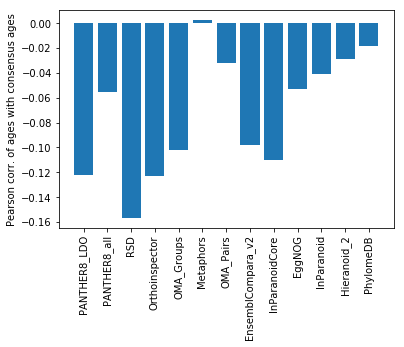

In [53]:
plt.bar(range(len(methods_to_corr_dict)), list(methods_to_corr_dict.values()), align='center')
plt.xticks(range(len(methods_to_corr_dict)), list(methods_to_corr_dict.keys()), rotation='vertical')
plt.ylabel("Pearson corr. of ages with consensus ages")
plt.savefig("figures/pearson_correlation_of_ages_from_diff_methods_with_consensus_ages.png")
plt.show()

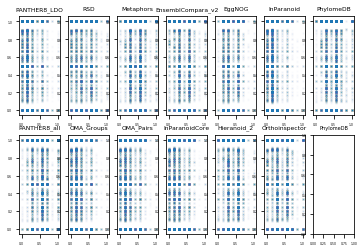

In [62]:
rows = len(dataset_list)
fig, ax_lists = plt.subplots(2, rows//2+1 , sharex=False, sharey=False)
for i in range(0,len(dataset_list)):
    dataset = dataset_list[i]
    ax_lists[i%2][i//2].set_title(dataset,fontsize=6)
    ax_lists[i%2][i//2].set_xlabel('', fontsize=2)
    ax_lists[i%2][i//2].tick_params(axis='both', which='major', labelsize=3)
    ax_lists[i%2][i//2].scatter(methods_to_scatter_dict[dataset][0],methods_to_scatter_dict[dataset][1],alpha=0.01,s=2)
    
ax_lists[1][i//2].set_title(dataset,fontsize=5)
ax_lists[1][i//2].tick_params(axis='both', which='major', labelsize=3)

plt.savefig("figures/scatter_of_age_est_methods_against_consensus_age.png",dpi=600)
plt.show()